In [1]:
import scipy as scp
import scipy.sparse
import scipy.sparse.linalg
from scipy.linalg import expm
from scipy.sparse import csr_array

from scipy.integrate import solve_ivp
from scipy.optimize import fmin
import matplotlib.pyplot as plt
import numpy as np

import functools 
from tqdm import tqdm
import os

from pathlib import Path

import seaborn as sns
import pandas as pd

# Tools


In [2]:
def exp_mat(M) :
    '''
    Computes the matrix exponential exp(M)
    
    Parameters
    ----------
    M : csr_array
        matrix

    Return
    ------
    exp(M) : csr_array
    '''
    return scp.sparse.csr_array(expm(M.toarray()))

# Spin and Jump operators


In [3]:
sx = 1/2 * scipy.sparse.csr_array([[0.,  1.],[1., 0.]])
sy = 1/2 * scipy.sparse.csr_array([[0., -1.j],[1.j, 0.]])
sz = 1/2 * scipy.sparse.csr_array([[1., 0.],[0., -1.]])

I = scipy.sparse.identity(2)

sp = ((sx + 1.j * sy) / 2).real
sm = ((sx - 1.j * sy) / 2).real

$$
\hat{\sigma}^{z}_{j} = \underbrace{\hat{I}\otimes\hat{I}\dots\hat{I}}_{j-1\ \mathrm{terms}}\otimes\hat{\sigma}^{z}\otimes\underbrace{\hat{I}\otimes\hat{I}\dots\otimes\hat{I}}_{N-j\ \mathrm{terms}},
$$


In [4]:
def sx_j(j, N):
    """
    Compute the operator $X_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $X_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sx] + [I] * (N - j))


def sy_j(j, N):
    """
    Compute the operator $Y_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $Y_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sy] + [I] * (N - j))


def sz_j(j, N):
    """
    Compute the operator $Z_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $Z_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sz] + [I] * (N - j))


def sp_j(j, N):
    """
    Compute the operator $S^+_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $S^+_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sp] + [I] * (N - j))


def sm_j(j, N):
    """
    Compute the operator $S^-_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $S^-_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sm] + [I] * (N - j))


def write_spin_operators(N) :
    """
    Save the spin operators in the folder results/time_dependent_GGE/heisenberg_spins/operators/N_N.

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    None

    Note
    ----
    - The operators are saved in a compressed format
    - 10 min long for N=14
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    os.makedirs(path, exist_ok=True)
    for k in range(1, N+1) :
        s = sx_j(k, N)
        scp.sparse.save_npz(path + f'/sx_k_{k}', s)

        s = sy_j(k, N)
        scp.sparse.save_npz(path + f'/sy_k_{k}', s)

        s = sz_j(k, N)
        scp.sparse.save_npz(path + f'/sz_k_{k}', s)

        s = sp_j(k, N)
        scp.sparse.save_npz(path + f'/sp_k_{k}', s)

        s = sm_j(k, N)
        scp.sparse.save_npz(path + f'/sm_k_{k}', s)


def write_Lk_operators(N) :
    """
    Save the Lk operators in the folder results/time_dependent_GGE/heisenberg_spins/operators/N_N.

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    None

    Note
    ----
    - The operators are saved in a compressed format
    - 1h30 long for N=14, already done from 1 to 5
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    for k in tqdm(range(1, N+1)) :
        kp1 = (k + 1) % N
        kp2 = (k + 2) % N

        if kp1 == 0:
            kp1 = N
        if kp2 == 0:
            kp2 = N

        sp_k = scp.sparse.load_npz(path + f'/sp_k_{k}.npz')
        sm_kp1 = scp.sparse.load_npz(path + f'/sm_k_{kp1}.npz')
        sp_kp2 = scp.sparse.load_npz(path + f'/sp_k_{kp2}.npz')

        Lk = 1/2 * (sp_k @ sm_kp1 + 1j * sm_kp1 @ sp_kp2)
        scp.sparse.save_npz(path + f'/Lk_{k}', Lk)


def compute_operators(N) :
    """
    Check if the operators are already computed, if not compute them.

    Parameters
    ----------
    N : int
        The number of spins in the system.
    """
   
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    
    try :
        files = os.listdir(path)
    except FileNotFoundError :
        write_spin_operators(N)
        write_Lk_operators(N)

    try :
        for k in range(1, N+1) :
            sx = scp.sparse.load_npz(path + f'/sx_k_{k}.npz')
            sy = scp.sparse.load_npz(path + f'/sy_k_{k}.npz')
            sz = scp.sparse.load_npz(path + f'/sz_k_{k}.npz')
            sp = scp.sparse.load_npz(path + f'/sp_k_{k}.npz')
            sm = scp.sparse.load_npz(path + f'/sm_k_{k}.npz')
    except FileNotFoundError :
        write_spin_operators(N)


    try :
        for k in range(1, N+1) :
            Lk = scp.sparse.load_npz(path + f'/Lk_{k}.npz')
    except FileNotFoundError :
        write_Lk_operators(N)


N = 5
write_spin_operators(N)
write_Lk_operators(N)
compute_operators(N)


100%|██████████| 5/5 [00:00<00:00, 46.55it/s]

# Dynamics


## Hamiltonian


In [5]:
def H_spin(N, J):
    """
    Compute the Hamiltonian of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    N : int
        The number of spins in the system.
    J : float
        The coupling constant.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Hamiltonian of the system.
    """
    H = 0

    for i in range(1, N+1):
        if i == N:
            ip1 = 1
        else:
            ip1 = i + 1

        sx_i = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sx_k_{i}.npz') 
        sx_ip1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sx_k_{ip1}.npz')

        sy_i = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sy_k_{i}.npz')
        sy_ip1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sy_k_{ip1}.npz')

        sz_i = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{i}.npz')
        sz_ip1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{ip1}.npz')

        H += J * (sx_i @ sx_ip1 + sy_i @ sy_ip1 + sz_i @ sz_ip1)

    return H

N = 5
J = 1

H = H_spin(N, J)
H.toarray()

array([[1.25+0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.25+0.j, 0.5 +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.5 +0.j, 0.25+0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       ...,
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.25+0.j, 0.5 +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.5 +0.j, 0.25+0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 1.25+0.j]])

## Lindbladian


Dissipators:


In [6]:
def dissipator_1(rho, J, N) :
    """
    Compute the 1st dissipator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The 1st dissipator of the system.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    D = 0
    for k in range(1, N+1) :
        sz_k = scp.sparse.load_npz(path + f'/sz_k_{k}.npz')
        D += J * (sz_k @ rho @ sz_k - 0.5 * (sz_k @ sz_k @ rho + rho @ sz_k @ sz_k))
    return D


def dissipator_2(rho, J, N) :
    """
    Compute the 2nd dissipator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The 2nd dissipator of the system.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    D = 0
    for k in range(1, N+1) :
        Lk = scp.sparse.load_npz(path + f'/Lk_{k}.npz')
        D += J * (Lk @ rho @ Lk.H - 0.5 * (Lk.H @ Lk @ rho + rho @ Lk.H @ Lk))
    return D


rho_test = scipy.sparse.identity(2**N)
dissipator_1(rho_test, J, N), dissipator_2(rho_test, J, N)



(<32x32 sparse matrix of type '<class 'numpy.float64'>'
 	with 0 stored elements (blocksize = 2x2) in Block Sparse Row format>,
 <32x32 sparse matrix of type '<class 'numpy.complex128'>'
 	with 224 stored elements (blocksize = 2x2) in Block Sparse Row format>)

Lindbladian


In [7]:
def lindblad_non_unitary(rho, epsilon, gamma, J, N) :
    """
    Compute the non-unitary part of the Lindblad equation of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The non-unitary part of the Lindbladian of the system.
    """
    L1 = epsilon * (gamma * dissipator_1(rho, J, N) + (1 - gamma) * dissipator_2(rho, J, N))
    return L1 


def lindblad(rho, H, epsilon, gamma, J, N) :
    """
    Compute the Lindblad equation of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    H : scipy.sparse.csr_matrix
        The Hamiltonian of the system.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Lindbladian of the system.
    """
    L0 = - 1j * (H @ rho - rho @ H)
    L1 = lindblad_non_unitary(rho, epsilon, gamma, J, N)
    return L0 + L1 


EPSILON = 0.1
GAMMA = 0.5
H = H_spin(N, J)
lindblad(rho_test, H, EPSILON, GAMMA, J, N)

<32x32 sparse matrix of type '<class 'numpy.complex128'>'
	with 160 stored elements (blocksize = 2x1) in Block Sparse Row format>

# Conserved quantities


In [8]:
def Ob(N) :
    """
    Boost operator

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The boost operator.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    O = 0


    for i in range(1, N+1):
        if i == N:
            ip1 = 1
        else:
            ip1 = i + 1

        sx_i = scp.sparse.load_npz(path + f'/sx_k_{i}.npz')
        sx_ip1 = scp.sparse.load_npz(path + f'/sx_k_{ip1}.npz')

        sy_i = scp.sparse.load_npz(path + f'/sy_k_{i}.npz')
        sy_ip1 = scp.sparse.load_npz(path + f'/sy_k_{ip1}.npz')

        sz_i = scp.sparse.load_npz(path + f'/sz_k_{i}.npz')
        sz_ip1 = scp.sparse.load_npz(path + f'/sz_k_{ip1}.npz')

        O += -1j * i * (sx_i @ sx_ip1 + sy_i @ sy_ip1 + sz_i @ sz_ip1)

    return O


Ob(N)



<32x32 sparse matrix of type '<class 'numpy.complex128'>'
	with 288 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [9]:
def Jh(N, J) :
    """
    Compute the heat current operator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    N : int
        The number of spins in the system.
    J : float
        The coupling constant.

    Returns
    -------
    float
        The value of the JH operator.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    JH = 0

    for k in range(1, N+1) :
        kp1 = (k + 1) % N
        kp2 = (k + 2) % N

        if kp1 == 0:
            kp1 = N
        if kp2 == 0:
            kp2 = N

        sx_k = scp.sparse.load_npz(path + f'/sx_k_{k}.npz')
        sx_kp1 = scp.sparse.load_npz(path + f'/sx_k_{kp1}.npz')
        sx_kp2 = scp.sparse.load_npz(path + f'/sx_k_{kp2}.npz')

        sy_k = scp.sparse.load_npz(path + f'/sy_k_{k}.npz')
        sy_kp1 = scp.sparse.load_npz(path + f'/sy_k_{kp1}.npz')
        sy_kp2 = scp.sparse.load_npz(path + f'/sy_k_{kp2}.npz')

        sz_k = scp.sparse.load_npz(path + f'/sz_k_{k}.npz')
        sz_kp1 = scp.sparse.load_npz(path + f'/sz_k_{kp1}.npz')
        sz_kp2 = scp.sparse.load_npz(path + f'/sz_k_{kp2}.npz')

        S_k = [sx_k, sy_k, sz_k]
        S_kp1 = [sx_kp1, sy_kp1, sz_kp1]
        S_kp2 = [sx_kp2, sy_kp2, sz_kp2]

        # just to make the formula of the cross product more readable
        u = S_k
        v = S_kp1
        S_cross = [
            u[1] @ v[2] - u[2] @ v[1], 
            u[2] @ v[0] - u[0] @ v[2], 
            u[0] @ v[1] - u[1] @ v[0],
        ]
        JH += J**2 * (S_cross[0] @ S_kp2[0] + S_cross[1] @ S_kp2[1] + S_cross[2] @ S_kp2[2])
    
    return JH


Jh(N, J)



<32x32 sparse matrix of type '<class 'numpy.complex128'>'
	with 368 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [10]:
# Hyperparameters
N = 5
J = 1
EPSILON = 0.1
GAMMA = 0.8
compute_operators(N)

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]



# Debug


In [14]:
N = 4
compute_operators(N)
C2_tmp = H_spin(N, J).toarray()
C3_tmp = Jh(N, J).toarray()
Ob_val_tmp = Ob(N).toarray()
C4_tmp = (Ob_val_tmp @ C3_tmp - C3_tmp @ Ob_val_tmp)
C5_tmp = (Ob_val_tmp @ C4_tmp - C4_tmp @ Ob_val_tmp)

In [15]:
# display((C2_tmp == C2).all())
# display((C3_tmp == C3).all())
# display((Ob_val_tmp == Ob_val).all())
# display((C4_tmp == C4).all())
# display((C5_tmp == C5).all())
display(((C4 @ C2 - C2 @ C4).toarray() == np.zeros_like(C2)).all())

False

In [77]:
C4 = Ob_val * C3 - C3 * Ob_val
C5 = Ob_val @ C4 - C4 @ Ob_val
display(((C4 @ C2 - C2 @ C4).toarray() == np.zeros_like(C2)).all())
display(((C5 @ C2 - C2 @ C5).toarray() == np.zeros_like(C2)).all())

False

False

In [78]:
((C4_tmp @ C2_tmp - C2_tmp @ C4_tmp) == np.zeros_like(C2_tmp)).all()

False

In [ ]:
zeros = np.zeros_like(C2)

def commutator_conservation(X) :
    return (X @ C2 - C2 @ X).toarray()

display('C2', (commutator_conservation(C2) == zeros).all())
display('C3', (commutator_conservation(C3) == zeros).all())
display('C4', (commutator_conservation(C4) == zeros).all())
display('C5', (commutator_conservation(C5) == zeros).all())


In [ ]:
np.diag(commutator_conservation(C5))


# GGE


In [11]:
def GGE(lagr, conserved_quantities) :
    """
    Compute the Generalized Gibbs Ensemble (GGE) density matrix, given the Lagrange multipliers and the conserved quantities.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    scipy.sparse.csr_matrix
        The GGE density matrix.
    """    
    exponent = 0
    for lambda_i, C_i in zip(lagr, conserved_quantities) :
        exponent -= lambda_i * C_i

    U = exp_mat(exponent)
    rho = U / scp.sparse.csr_matrix.trace(U)
    return rho

test_GGE = GGE([1, 1, 1, 1], Cs); test_GGE

<32x32 sparse array of type '<class 'numpy.complex128'>'
	with 252 stored elements in Compressed Sparse Row format>

In [12]:
def avg_GGE(lagr, conserved_quantities, O) :
    """
    Compute the average of an observable in the Generalized Gibbs Ensemble (GGE), given the Lagrange multipliers, the conserved quantities, and the observable.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    O : scipy.sparse.csr_matrix
        The observable.

    Returns
    -------
    float
        The average of the observable in the GGE.
    """
    rho = GGE(lagr, conserved_quantities)
    return scp.sparse.csr_matrix.trace(rho @ O)

avg_GGE([1] * len(Cs), Cs, sp_j(1, N))

0j

# EOM Lagrange multipliers


In [13]:
def write_Cjdot_operators(Cs, N) :
    """
    Check if the operators Cjdot_D1_Cj and Cjdot_D2_Cj are already computed, if not compute them.

    Parameters
    ----------
    Cs : list of scipy.sparse.csr_matrix
        The conserved quantities.
    N : int
        The number of spins in the system.
    """
    paths = [
        f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D1_C{2}_sum.npz',
        f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D2_C{2}_sum.npz',
    ]
    
    compute = False

    for path in paths :
        check = Path(path)
        if not check.exists():
            compute = True

    if compute == True :
        for j, C in enumerate(Cs) :
            D1 = np.zeros_like(Cs[j].toarray())
            for k in range(1, N+1) :
                Sz = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{k}.npz')
                D1 += Sz @ Cs[j] @ Sz 
            D1 = J * scp.sparse.csr_array(D1) - J * N / 4 * Cs[j] 
            scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D1_C{j + 2}_sum.npz', D1)

            D2 = np.zeros_like(Cs[j].toarray())
            for k in range(1, N+1) :
                Lk = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Lk_{k}.npz')
                Lk_dag = Lk.H
                D2 += 2 * Lk_dag @ Cs[j] @ Lk - (Lk_dag @ Lk @ Cs[j] + Cs[j] @ Lk_dag @ Lk)
            D2 = J / 2 * scp.sparse.csr_array(D2) 
            scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D2_C{j + 2}_sum.npz', D2)


write_Cjdot_operators(Cs, N)


In [14]:
def chi(lagr, conserved_quantities) :
    """
    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    O : scipy.sparse.csr_matrix
        The observable.

    Returns
    -------
    float
        The susceptibility of the observable in the GGE.
    """
    n = len(conserved_quantities)
    chi_mat = np.zeros((n, n))
    for i in range(n) :
        for j in range(n) :
            chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \
                            - avg_GGE(lagr, conserved_quantities, conserved_quantities[i]) * avg_GGE(lagr, conserved_quantities, conserved_quantities[j])
    return chi_mat
    


def force(lagr, conserved_quantities) :
    """
    Compute the force acting on the Lagrange multipliers, given the Lagrange multipliers, the conserved quantities.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    list of float
        The force acting on the Lagrange multipliers.
    """
    rho_GGE = GGE(lagr, conserved_quantities)

    n = len(conserved_quantities)
    vect = np.zeros(n)
    for j in range(n) :

        D1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D1_C{j + 2}_sum.npz')
        D2 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D2_C{j + 2}_sum.npz')

        # first_term = scp.sparse.csr_matrix.trace(FIRST_TERM[j] @ rho_GGE)
        first_term = 0
        second_term = scp.sparse.csr_matrix.trace(D1 @ rho_GGE) 
        third_term = scp.sparse.csr_matrix.trace(D2 @ rho_GGE)  

        vect[j] = - 1j * first_term + EPSILON * GAMMA * second_term + EPSILON * (1 - GAMMA) * third_term

    chi_mat = chi(lagr, conserved_quantities)
    chi_mat_inv = np.linalg.inv(chi_mat)

    f = -chi_mat_inv @ vect
    return f



display(chi([0]*len(Cs), Cs))

force([0]*len(Cs), Cs)

C:\Users\antho\AppData\Local\Temp\ipykernel_18348\4046068342.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


array([[ 0.9375 ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.46875,  0.     , -3.75   ],
       [ 0.     ,  0.     ,  3.75   ,  0.     ],
       [ 0.     , -3.75   ,  0.     , 67.03125]])

C:\Users\antho\AppData\Local\Temp\ipykernel_18348\4046068342.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  vect[j] = - 1j * first_term + EPSILON * GAMMA * second_term + EPSILON * (1 - GAMMA) * third_term


array([0.        , 0.00041667, 0.        , 0.        ])

# Numerical integration


## Initial state: Néel configuration


up, down, up, down, ...


In [15]:
def generate_neel(N) :
    """
    Generate the Neel state for a N-spin system.

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Neel state.
    """
    up = np.array([1, 0])
    down = np.array([0, 1])

    state = 1

    # starts with up
    for i in range(1, N+1) :
        if i % 2 == 1 :
            state = np.kron(state, up)
        else :
            state = np.kron(state, down)

    rho = scp.sparse.csr_matrix(state).T @ scp.sparse.csr_matrix(state)
    return rho


N = 5
GGE_neel = generate_neel(8).toarray(); display(GGE_neel)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

array([ 8.62092495e-01, -3.67273615e-06, -3.59519770e-01,  9.22470897e-07])

'Total Spin Sz: 0j'

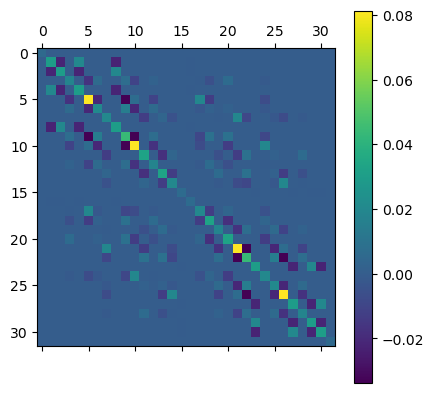

In [16]:
def find_lagr_closest_GGE(rho, conserved_quantities) :
    """
    Find the closest GGE density matrix to the Neel state, given the Lagrange multipliers and the conserved quantities.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix to be written in the GGE formalism.
    lagr : list of float
        The Lagrange multipliers.
    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    scipy.sparse.csr_matrix
        The closest GGE density matrix to the Neel state.
    """

    solution = fmin(lambda x: np.linalg.norm(GGE(x, conserved_quantities).toarray() - rho), x0=np.zeros(len(conserved_quantities)), disp=False)
    return solution


def fetch_neel(N) :
    """
    Fetch the Neel state for a N-spin system.

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Neel state.
    """

    try :
        lambdas_0 = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/neel_lambda_0/lambdas_0_N_{N}.txt')
    except FileNotFoundError :
        GGE_neel = generate_neel(N)
        lambdas_0 = find_lagr_closest_GGE(GGE_neel, Cs)
        np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/neel_lambda_0/lambdas_0_N_{N}.txt', lambdas_0)
    return lambdas_0



GGE_neel = generate_neel(N)
lambdas_GGE_neel = find_lagr_closest_GGE(GGE_neel, Cs); display(lambdas_GGE_neel)

total_spin = 0
for j in range(1, N+1) :
    total_spin += avg_GGE(lambdas_GGE_neel, Cs, sp_j(j, N))
display(f"Total Spin Sz: {total_spin}")

plt.matshow(GGE(lambdas_GGE_neel, Cs).toarray().real)
plt.colorbar()
plt.savefig('results/time_dependent_GGE/heisenberg_spins/GGE_neel.png')

## Params


In [17]:
# Hyperparameters
N = 8
J = 1
EPSILON = 0.1
GAMMA = 0.8
compute_operators(N)

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]

# Initial conditions
lambdas_0 = fetch_neel(N)

# Time grid
tmin = 0
tmax = 90
t_eval = np.linspace(tmin, tmax, 100)

write_Cjdot_operators(Cs, N)


## Exact time evolution


In [18]:
def avg_general(rho, O) :
    """
    Compute the average of an observable in a density matrix.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix.
    O : scipy.sparse.csr_matrix
        The observable.

    Returns
    -------
    float
        The average of the observable.
    """
    return scp.sparse.csr_matrix.trace(rho @ O)


def time_evolution(rho0, H, epsilon, gamma, J, N, t) :
    """
    Compute the time evolution of a density matrix, given the initial density matrix, the Hamiltonian, the perturbation strength, the relative strength, the coupling constant, the number of spins, and the time.

    Parameters
    ----------
    rho0 : scipy.sparse.csr_matrix
        The initial density matrix.
    H : scipy.sparse.csr_matrix
        The Hamiltonian.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins.
    t : float
        The time.

    Returns
    -------
    scipy.sparse.csr_matrix
        The density matrix at time t.
    """
    def f(t, rho) :
        return lindblad(rho.reshape(H.shape), H, epsilon, gamma, J, N).flatten()

    rho0 = rho0.toarray()
    sol = solve_ivp(f, [0, t[-1]], rho0.flatten(), t_eval=t, method='RK45')
    return sol


def get_rhos_exact(shape) :
    rhos_re = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_real.npz').T.toarray().reshape((-1, *shape))
    rhos_im = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_im.npz').T.toarray().reshape((-1, *shape))
    return rhos_re + 1j * rhos_im




compute


In [ ]:
lambdas_0 = fetch_neel(N)
GGE_neel = GGE(lambdas_0, Cs)
Hs = H_spin(N, J)

sol_exact = time_evolution(GGE_neel, Hs, EPSILON, GAMMA, J, N, t_eval)

os.makedirs(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}', exist_ok=True)
np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt', sol_exact.t)
scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_real', csr_array(sol_exact.y.real))
scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_im', csr_array(sol_exact.y.imag))

#### Measurement Observables


In [22]:
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt')

compute


In [334]:
rhos_exact = get_rhos_exact(H.shape)


# Average current
JHs = []
for i, t in enumerate(ts) :
    rho_exact = scp.sparse.csr_matrix(rhos_exact[i])
    JHs.append(avg_general(rho_exact, Jh(N, J)))

np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.txt', -np.array(JHs).real / N)


# Spin neighbor correlation
Y_spin_cor = []

j = 3
sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')
for i, t in enumerate(ts) :
    rho_exact = scp.sparse.csr_matrix(rhos_exact[i])
    avg_corr = avg_general(rho_exact, sz_j @ sz_jp1) 
    Y_spin_cor.append(-4 * avg_corr)

np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/spin_neighbor_correlation.txt', np.array(Y_spin_cor).real)



Plot


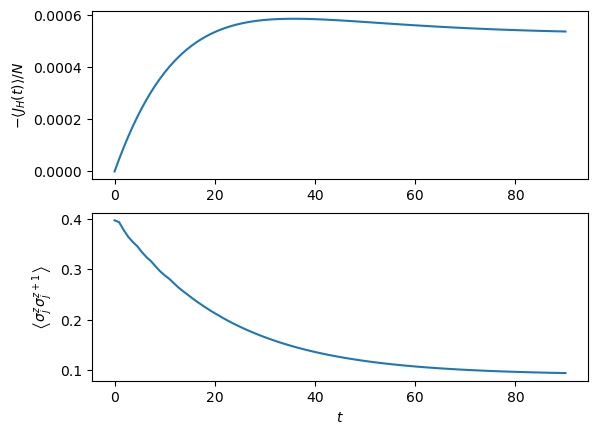

In [8]:
plt.subplot(211)
JHs = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.txt')
plt.plot(ts, JHs)
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 
# plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.pdf")


plt.subplot(212)
spin_corr = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/spin_neighbor_correlation.txt')
plt.plot(ts, spin_corr)
plt.xlabel(r'$t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')


plt.savefig("results/time_dependent_GGE/heisenberg_spins/sol_exact/observables_exact.pdf")

## GGE evolution


In [20]:
folder = 'time_evol_GGE'

Compute


In [20]:
F = lambda t, s: force(s, Cs)

sol = solve_ivp(F, [tmin, tmax], lambdas_0, t_eval=t_eval)

all_params = np.vstack([sol.t, sol.y]).T
np.savetxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/time_dependent_params.txt", all_params)

C:\Users\antho\AppData\Local\Temp\ipykernel_12980\4046068342.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  vect[j] = - 1j * first_term + EPSILON * GAMMA * second_term + EPSILON * (1 - GAMMA) * third_term
C:\Users\antho\AppData\Local\Temp\ipykernel_12980\4046068342.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


#### Measurement Observables


In [21]:
time_dependent_params = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/time_dependent_params.txt", unpack=True)
t_eval = time_dependent_params[0]
lagr = time_dependent_params[1:]


Compute


In [22]:
# Heat current
Y = []
for i, t in enumerate(t_eval) :
    avg_current = avg_GGE(lagr.T[i], Cs, -Jh(N, J)) / N
    Y.append(avg_current)

np.savetxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/avg_current.txt", np.vstack([t_eval, np.array(Y)]).T.real)


# spin neighbor correlation
j = 3

Y = []
for i, t in enumerate(t_eval) :
    sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
    sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')

    avg_corr = avg_GGE(lagr.T[i], Cs, sz_j @ sz_jp1) 
    Y.append(-4 * avg_corr) # factor 4 because of the normalization of the spin operators

np.savetxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/spin_neighbor_correlation.txt", np.vstack([t_eval, np.array(Y)]).T.real)



Plot


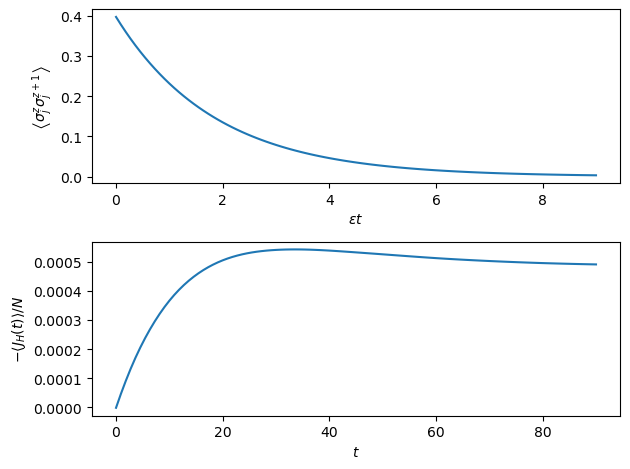

In [28]:
plt.subplot(212)
t_eval, Y = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/avg_current.txt", unpack=True)

plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 


plt.subplot(211)
t_eval, Y = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/spin_neighbor_correlation.txt", unpack=True)

plt.plot(EPSILON * t_eval, Y)
plt.xlabel(r'$\epsilon t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')

fig = plt.gcf()
fig.tight_layout()


plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/{folder}/observables_GGE.pdf")

## Variational method


In [ ]:
def lindblad_norm(lagr, conserved_quantities, H, epsilon, gamma, J, N) :
    """
    Compute the norm of the Lindbladian of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.
    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.
    H : scipy.sparse.csr_matrix
        The Hamiltonian.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    float
        The norm of the Lindbladian.
    """
    # check that lagr has not NaN values
    assert not np.isnan(lagr).any()
    rho_GGE = GGE(lagr, conserved_quantities)
    return np.linalg.norm(lindblad(rho_GGE,  H, epsilon, gamma, J, N).toarray(), 'nuc')


lambdas_0 = fetch_neel(N)
Hs = H_spin(N, J)
lindblad_norm(lambdas_0, Cs, Hs, EPSILON, GAMMA, J, N)


0.13196521040906622

In [ ]:
def optimize(l, lagr_0, conserved_quantities, H, epsilon, gamma, J, N) :
    '''
    Parameters
    ----------
    l : function
        The function to minimize.
    lagr_0 : list of float
        The initial Lagrange multipliers.
    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.
    H : scipy.sparse.csr_matrix
        The Hamiltonian.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Note
    ----
    fmin[0]     # xopt 
    fmin[1]     # fopt
    fmin[2]     # nb iteration
    fmin[3]     # funcalls
    fmin[4]     # warnflag
    fmin[5]     # solution at each iterations
    '''
    sols = {}
    solution = fmin(lambda x: l(x, conserved_quantities, H, epsilon, gamma, J, N), lagr_0, retall=True, full_output=True)
    sols['history'] = np.array(solution[5])
    sols['lagr_best'] = solution[0]
    sols['rho_best'] = GGE(sols['lagr_best'], conserved_quantities)
    sols['fopt'] = np.array([solution[1]])

    np.savetxt(f'{folder}/history.txt', sols['history'])
    np.savetxt(f'{folder}/loss_rho_best.txt', sols['fopt'])
    np.savetxt(f'{folder}/lagr_best.txt', sols['lagr_best'])
    np.savetxt(f'{folder}/rho_best.txt', np.atleast_1d(sols['rho_best'].toarray()))

    return sols

In [ ]:
folder = 'results/time_dependent_GGE/heisenberg_spins/variational'
os.makedirs(folder, exist_ok=True)

l = lindblad_norm
lagr_0 = fetch_neel(N)
conserved_quantities = Cs
H = H_spin(N, J)



Compute


In [ ]:
optimize(l, lagr_0, conserved_quantities, H, EPSILON, GAMMA, J, N)

Optimization terminated successfully.
         Current function value: -6.535283
         Iterations: 66
         Function evaluations: 121


{'history': array([[ 1.58283761e+00, -3.51419571e-05,  6.02500328e-06,
         -9.55266726e-07],
        [ 1.42455385e+00, -3.64597805e-05,  6.25094091e-06,
         -9.91089228e-07],
        [ 1.42455385e+00, -3.64597805e-05,  6.25094091e-06,
         -9.91089228e-07],
        [ 1.42455385e+00, -3.64597805e-05,  6.25094091e-06,
         -9.91089228e-07],
        [ 1.31573377e+00, -3.53890490e-05,  6.34978862e-06,
         -1.09631783e-06],
        [ 1.11540588e+00, -3.55743679e-05,  6.59337762e-06,
         -1.07075698e-06],
        [ 1.11540588e+00, -3.55743679e-05,  6.59337762e-06,
         -1.07075698e-06],
        [ 8.30680599e-01, -3.80341333e-05,  7.17807947e-06,
         -1.15096114e-06],
        [ 4.64417540e-01, -3.67988884e-05,  7.30858934e-06,
         -1.32459882e-06],
        [ 4.64417540e-01, -3.67988884e-05,  7.30858934e-06,
         -1.32459882e-06],
        [-1.53830098e-01, -3.70642387e-05,  8.72704754e-06,
         -1.39449250e-06],
        [-1.53830098e-01, -3.706

#### Measurement Observables


Compute


In [ ]:
lambdas_inf = np.loadtxt(f'{folder}/lagr_best.txt')

# Heat current
Y = []
avg_current = avg_GGE(lambdas_inf, Cs, -Jh(N, J)) / N
Y.append(avg_current)

np.savetxt(f"{folder}/avg_current.txt", np.atleast_1d(Y).real)


# spin neighbor correlation
j = 3

Y = []
sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')

avg_corr = avg_GGE(lambdas_inf, Cs, sz_j @ sz_jp1) 
Y.append(-4 * avg_corr) # factor 4 because of the normalization of the spin operators

np.savetxt(f"{folder}/spin_neighbor_correlation.txt", np.atleast_1d(Y).real)


Plot


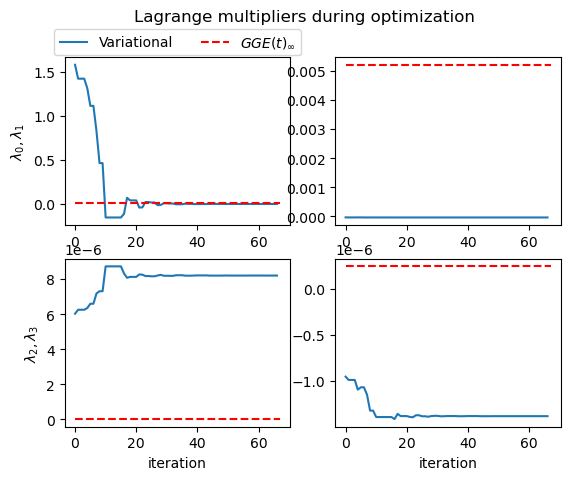

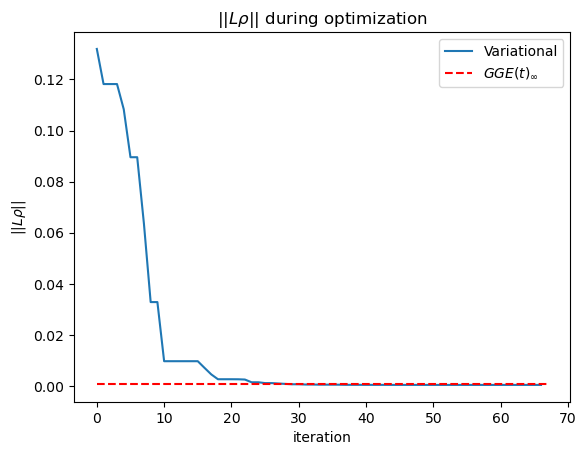

In [ ]:
folder_GGE = 'time_evol_GGE'

lambdas_history = np.loadtxt(f'{folder}/history.txt').T
lambdas_GGE = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/{folder_GGE}/time_dependent_params.txt', unpack=True)
lambdas_GGE_inf = lambdas_GGE.T[-1][1:]



plt.subplot(221)
plt.plot(lambdas_history[0], label='Variational')
plt.hlines(lambdas_GGE[1][-1], 0, len(lambdas_history[0]), color='red', linestyle='--', label=r'$GGE(t)_\infty$')
plt.ylabel(r'$\lambda_0, \lambda_1$')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.21), ncol=2)

plt.subplot(222)
plt.plot(lambdas_history[1])
plt.hlines(lambdas_GGE[2][-1], 0, len(lambdas_history[1]), color='red', linestyle='--')

plt.subplot(223)
plt.plot(lambdas_history[2])
plt.hlines(lambdas_GGE[3][-1], 0, len(lambdas_history[2]), color='red', linestyle='--')
plt.xlabel('iteration')
plt.ylabel(r'$\lambda_2, \lambda_3$')

plt.subplot(224)
plt.plot(lambdas_history[3])
plt.hlines(lambdas_GGE[4][-1], 0, len(lambdas_history[3]), color='red', linestyle='--')
plt.xlabel('iteration')


plt.suptitle('Lagrange multipliers during optimization')
plt.savefig(f"{folder}/lagr_multipliers_afo_iterations.pdf")


plt.figure()
norms = []
for i, lagr in enumerate(lambdas_history.T) :
    norm_i = lindblad_norm(lagr, Cs, H, EPSILON, GAMMA, J, N)
    norms.append(norm_i)
gge_norms = lindblad_norm(lambdas_GGE_inf, Cs, H, EPSILON, GAMMA, J, N)
plt.plot(norms, label='Variational')
plt.hlines(gge_norms, 0, len(norms), color='red', linestyle='--', label=r'$GGE(t)_\infty$')
plt.ylabel(r'$||L \rho||$')
plt.xlabel('iteration')

plt.legend()
plt.title(r'$||L \rho||$ during optimization')
plt.savefig(f"{folder}/lindblad_norm_afo_iterations.pdf")



### test from various initial conditions


In [ ]:
def init_random_lambdas(bounds, Nrep) :
    """
    Initialize the Lagrange multipliers for a N-spin system with random values within the bounds.
    Returns a list of sets of Lagrange multipliers.

    Parameters
    ----------
    bounds : list of tuple
        The bounds for each Lagrange multiplier.
    Nrep : int
        The number of sets of Lagrange multipliers.

    Returns
    -------
    list of numpy.ndarray
        The Lagrange multipliers.
    """
    bounds_ = np.array(bounds).T
    lambdas_0 = []
    for i in range(Nrep) :
        lambdas_0.append(np.random.uniform(low=bounds_[0], high=bounds_[1], size=(1,len(Cs)))[0])
    return lambdas_0

In [ ]:
# Hyperparameters
N = 8
J = 1
EPSILON = 0.1
GAMMA = 0.8
compute_operators(N)

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]

# Time grid
# t_eval = np.arange(0, np.pi, 0.1)
tmin = 0
tmax = 90
t_eval = np.linspace(tmin, tmax, 100)

# Initial conditions
dt = t_eval[1] - t_eval[0]


In [ ]:
folder_path = 'results/time_dependent_GGE/heisenberg_spins/variational'

bounds = [(-1, 1), (-1, 1), (-1, 1), (-1, 1)]
Nrep = 100
lambdas_0 = init_random_lambdas(bounds, Nrep)

l = lindblad_norm
conserved_quantities = Cs
H = H_spin(N, J)

Compute


In [ ]:
for i_rep, lagr_0 in tqdm(enumerate(lambdas_0)) :
    folder = f'{folder_path}/rep_{i_rep}'
    os.makedirs(folder, exist_ok=True)
    optimize(l, lagr_0, conserved_quantities, H, EPSILON, GAMMA, J, N)

Plot


40it [00:00, 91.98it/s] 


Text(0, 0.5, '$\\lambda_3$')

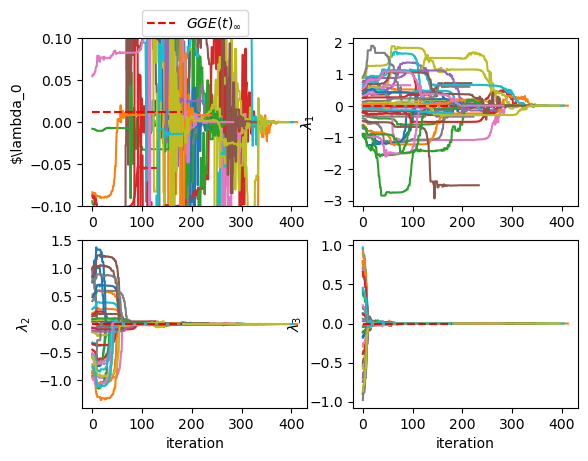

In [ ]:
last_rep = 40

for i_rep, lagr_0 in tqdm(enumerate(lambdas_0[:last_rep])) :
    folder = f'{folder_path}/rep_{i_rep}'
    lambdas_history = np.loadtxt(f'{folder}/history.txt').T

    plt.subplot(221)
    plt.plot(lambdas_history[0])

    plt.subplot(222)
    plt.plot(lambdas_history[1])

    plt.subplot(223)
    plt.plot(lambdas_history[2])

    plt.subplot(224)
    plt.plot(lambdas_history[3])


lambdas_GGE = np.loadtxt('results/time_dependent_GGE/heisenberg_spins/first_try/time_dependent_params.txt', unpack=True)
lambdas_GGE_inf = lambdas_GGE.T[-1][1:]

plt.subplot(221)
plt.hlines(lambdas_GGE[1][-1], 0, len(lambdas_history[0]), color='red', linestyle='--', label=r'$GGE(t)_\infty$')
plt.ylabel(r'$\lambda_0')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.21), ncol=2)
plt.ylim(-0.1, 0.1)

plt.subplot(222)
plt.ylabel(r'$\lambda_1$')
plt.hlines(lambdas_GGE[2][-1], 0, len(lambdas_history[1]), color='red', linestyle='--')

plt.subplot(223)
plt.hlines(lambdas_GGE[3][-1], 0, len(lambdas_history[2]), color='red', linestyle='--')
plt.xlabel('iteration')
plt.ylabel(r'$\lambda_2$')

plt.subplot(224)
plt.hlines(lambdas_GGE[4][-1], 0, len(lambdas_history[3]), color='red', linestyle='--')
plt.xlabel('iteration')
plt.ylabel(r'$\lambda_3$')
    

In [ ]:
collect_lagr_best = []
for i_rep, lagr_0 in tqdm(enumerate(lambdas_0[:last_rep])) :
    folder = f'{folder_path}/rep_{i_rep}'
    lagr_best = np.loadtxt(f'{folder}/lagr_best.txt')
    collect_lagr_best.append(lagr_best)

collect_lagr_best = np.array(collect_lagr_best)

40it [00:00, 940.48it/s]


In [ ]:
collect_lagr_best.T.shape

(4, 40)

In [ ]:
collect_loss_best = []
for i_rep, lagr_0 in tqdm(enumerate(lambdas_0[:last_rep])) :
    folder = f'{folder_path}/rep_{i_rep}'
    loss_best = np.loadtxt(f'{folder}/loss_rho_best.txt')
    collect_loss_best.append(loss_best)

collect_loss_best = np.array(collect_loss_best)

40it [00:00, 733.26it/s]


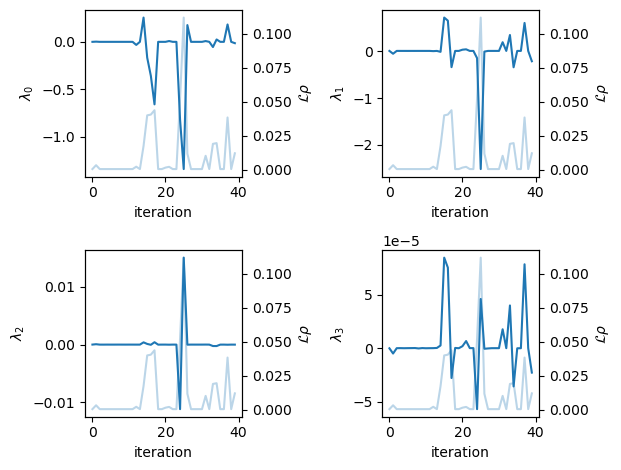

In [ ]:

plt.subplot(221)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(collect_loss_best, alpha=0.3)
ax.plot(collect_lagr_best.T[0], label=r'$\lambda_0$')
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_ylabel(r'$\lambda_0$')
ax.set_xlabel('iteration')

plt.subplot(222)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(collect_loss_best, alpha=0.3)
ax.plot(collect_lagr_best.T[1], label=r'$\lambda_1$')
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_ylabel(r'$\lambda_1$')
ax.set_xlabel('iteration')

plt.subplot(223)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(collect_loss_best, alpha=0.3)
ax.plot(collect_lagr_best.T[2], label=r'$\lambda_0$')
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_ylabel(r'$\lambda_2$')
ax.set_xlabel('iteration')

plt.subplot(224)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(collect_loss_best, alpha=0.3)
ax.plot(collect_lagr_best.T[3], label=r'$\lambda_1$')
ax.set_ylabel(r'$\lambda_3$')
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_xlabel('iteration')

fig = plt.gcf()
fig.tight_layout()

plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/variational/lagr_vs_iteration.pdf")


In [ ]:
collect_JH_best = []
for i_rep, lagr_0 in tqdm(enumerate(lambdas_0[:last_rep])) :
    folder = f'{folder_path}/rep_{i_rep}'
    lagr_best = np.loadtxt(f'{folder}/lagr_best.txt')
    avg_current = avg_GGE(lagr_best, Cs, -Jh(N, J)) / N
    collect_JH_best.append(avg_current)

collect_JH_best = np.array(collect_JH_best)

40it [01:01,  1.55s/it]


percentage close to GGE: 60.0% (tolerance: 0.0001)


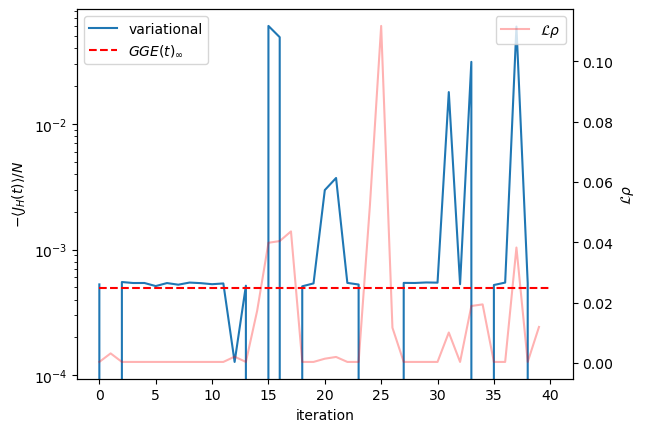

In [ ]:
_, current_time_evol = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", unpack=True)

last = current_time_evol[-1]

plt.plot(collect_JH_best.real, label='variational')
plt.hlines(last, 0, last_rep, color='red', linestyle='--', label=r'$GGE(t)_\infty$')
plt.xlabel('iteration')
# plt.ylim(0.00045, 0.00055)
plt.yscale('log')
plt.ylabel(r'$-\left< J_H(t) \right> / N$')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(collect_loss_best, alpha=0.3, label=r'$\mathcal{L}\rho$', color='red')
ax2.set_ylabel(r'$\mathcal{L}\rho$')

ax.legend(loc='upper left')
ax2.legend()

tol_close = 10**(-4)
isclose = np.abs(collect_JH_best - last) < tol_close
print(f'percentage close to GGE: {np.sum(isclose) / len(isclose) * 100}% (tolerance: {tol_close})')

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


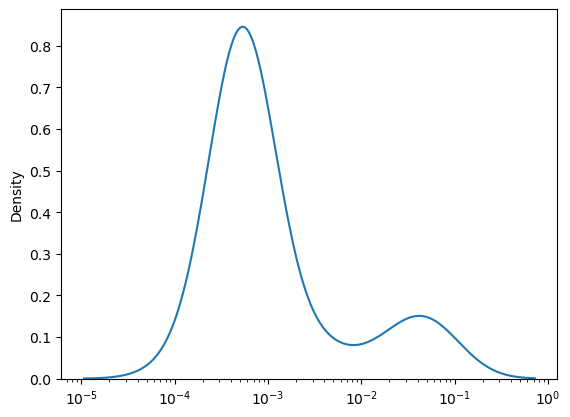

In [ ]:
kde = sns.kdeplot(data=collect_JH_best.real, log_scale=True)


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


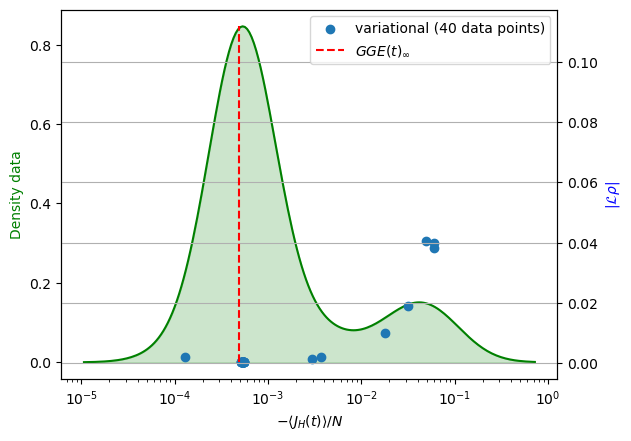

In [ ]:
ax1 = plt.gca()
ax2 = ax1.twinx()

xkde = kde.lines[0].get_xdata()
ykde = kde.lines[0].get_ydata()

ax1.plot(xkde, ykde, color='green')
ax1.set_ylabel('Density data', color='green')
ax1.fill_between(xkde, ykde, color='green', alpha=0.2, zorder=-1)



plt.scatter(collect_JH_best, collect_loss_best, label=f'variational ({len(collect_JH_best)} data points)', zorder=1)


_, current_time_evol = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/force_3/avg_current.txt", unpack=True)
last = current_time_evol[-1]
y_min = min(collect_loss_best)
y_max = max(collect_loss_best)
ax2.vlines(last, y_min, y_max, color='red', linestyle='--', label=r'$GGE(t)_\infty$')


ax2.set_ylabel(r'$|\mathcal{L}\rho|$', color='blue')
ax1.set_xlabel(r'$-\left< J_H(t) \right> / N$')
ax2.set_xscale('log')
ax2.grid()
ax2.legend()

plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/variational/JH_vs_loss.pdf")

In [ ]:
j = 3
sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')

collect_spincorr_best = []
for i_rep, lagr_0 in tqdm(enumerate(lambdas_0[:last_rep])) :
    folder = f'{folder_path}/rep_{i_rep}'
    lagr_best = np.loadtxt(f'{folder}/lagr_best.txt')
    avg_spincorr = avg_GGE(lagr_best, Cs, sz_j @ sz_jp1)
    collect_spincorr_best.append(-4 * avg_spincorr)

collect_spincorr_best = np.array(collect_spincorr_best)

40it [00:02, 15.25it/s]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


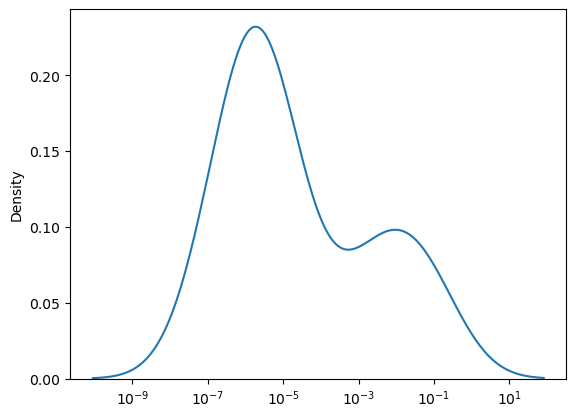

In [ ]:
kde = sns.kdeplot(data=collect_spincorr_best.real, log_scale=True)


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


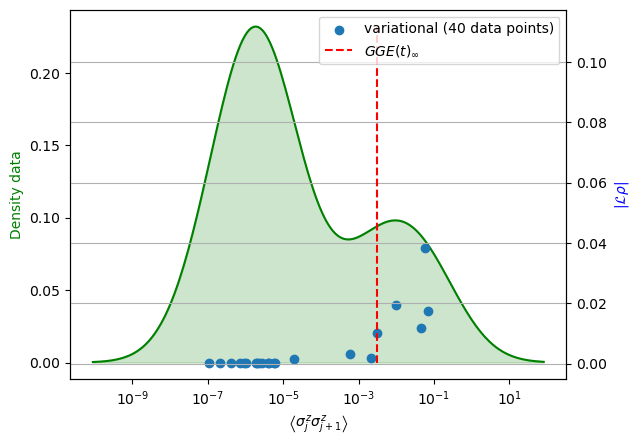

In [ ]:
ax1 = plt.gca()
ax2 = ax1.twinx()

xkde = kde.lines[0].get_xdata()
ykde = kde.lines[0].get_ydata()

ax1.plot(xkde, ykde, color='green')
ax1.set_ylabel('Density data', color='green')
ax1.fill_between(xkde, ykde, color='green', alpha=0.2, zorder=-1)



plt.scatter(collect_spincorr_best, collect_loss_best, label=f'variational ({len(collect_spincorr_best)} data points)', zorder=1)


_, corr_time_evol = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/force_3/spin_neighbor_correlation.txt", unpack=True)
last = corr_time_evol[-1]
y_min = min(collect_loss_best)
y_max = max(collect_loss_best)
ax2.vlines(last, y_min, y_max, color='red', linestyle='--', label=r'$GGE(t)_\infty$')


ax2.set_ylabel(r'$|\mathcal{L}\rho|$', color='blue')
ax1.set_xlabel(r'$\left< \sigma_j^z \sigma_{j+1}^z \right>$')
ax2.set_xscale('log')
ax2.grid()
ax2.legend()

plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/variational/spincorr_vs_loss.pdf")

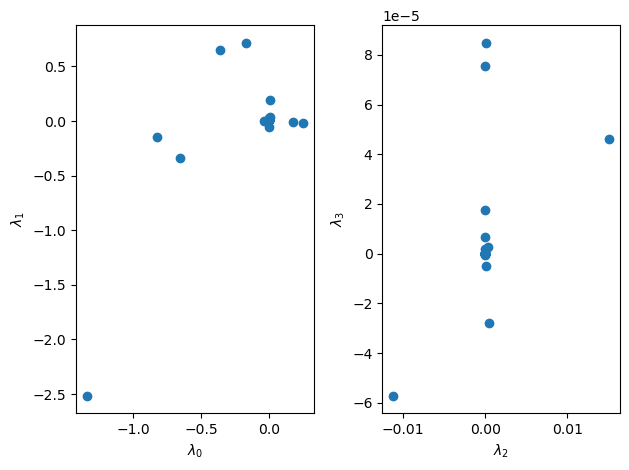

In [ ]:

plt.subplot(121)
ax = plt.gca()
ax.scatter(collect_lagr_best.T[0], collect_lagr_best.T[1])
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_xlabel(r'$\lambda_0$')
ax.set_ylabel(r'$\lambda_1$')

plt.subplot(122)
ax = plt.gca()
ax.scatter(collect_lagr_best.T[2], collect_lagr_best.T[3])
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_xlabel(r'$\lambda_2$')
ax.set_ylabel(r'$\lambda_3$')

fig = plt.gcf()
fig.tight_layout()

## Comparison strategies


### Comparison Exact vs GGE


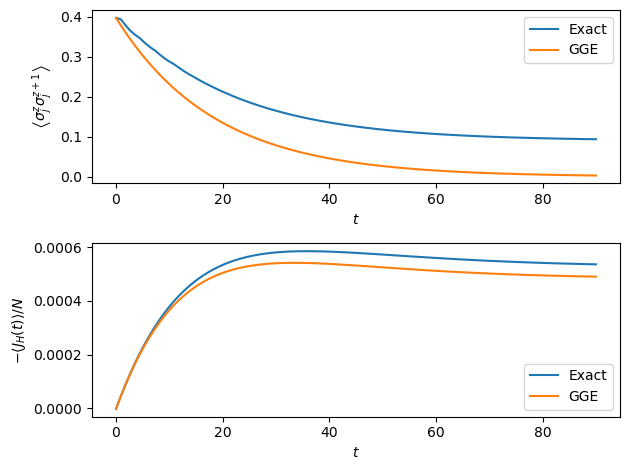

In [26]:
folder_GGE = 'time_evol_GGE'
folder_exact = 'sol_exact'


plt.subplot(2, 1, 2)

t_eval, Y = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder_GGE}/avg_current.txt", unpack=True)
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/{folder_exact}/N_{N}/ts.txt')
JHs_exact = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/{folder_exact}/N_{N}/avg_current.txt')

plt.plot(ts, JHs_exact, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 
plt.legend()



plt.subplot(2, 1, 1)
t_eval, Y = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder_GGE}/spin_neighbor_correlation.txt", unpack=True)
Y_exact = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/{folder_exact}/N_{N}/spin_neighbor_correlation.txt')
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/{folder_exact}/N_{N}/ts.txt')

plt.plot(ts, Y_exact, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')
plt.legend()

plt.gcf().tight_layout()

plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/{folder_GGE}/observables_exact_VS_GGE.pdf")


### and VS variational


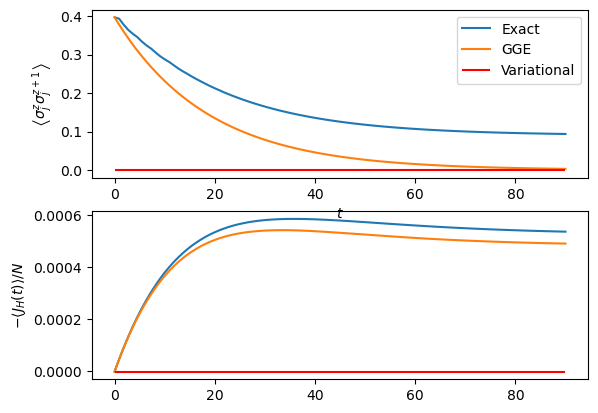

In [31]:
folder_GGE = 'time_evol_GGE'
folder_exact = 'sol_exact'
folder_var = 'variational'

plt.subplot(2, 1, 2)

t_eval, Y = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder_GGE}/avg_current.txt", unpack=True)
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/{folder_exact}/N_{N}/ts.txt')
JHs_exact = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/{folder_exact}/N_{N}/avg_current.txt')

val_variational = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder_var}/avg_current.txt")

plt.plot(ts, JHs_exact, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.hlines(val_variational, 0, t_eval[-1], label='Variational', color='r')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 



plt.subplot(2, 1, 1)
t_eval, Y = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder_GGE}/spin_neighbor_correlation.txt", unpack=True)
Y_exact = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/{folder_exact}/N_{N}/spin_neighbor_correlation.txt')
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/{folder_exact}/N_{N}/ts.txt')

val_variational = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder_var}/spin_neighbor_correlation.txt")

plt.plot(ts, Y_exact, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.hlines(val_variational, 0, t_eval[-1], label='Variational', color='r')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')
plt.legend()


plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/{folder_var}/observables_exact_VS_GGE.pdf")
